# 라이브러리 선언

In [5]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 환경 설정

In [6]:
class Queens():
    def __init__(self, n):
        self.size = n
        self.board = np.zeros((n, n), dtype=int)
        self.reset()

    def put(self, x, y):
        self.board[x][y] = 1


    def reset(self):
        self.board = np.zeros((self.size, self.size), dtype=int)
        return self.board

# 보드판 검사

In [7]:
def queencheck(board):
    b1 = np.sum(board, axis=0)
    b2 = np.sum(board, axis=1)
    c1 = np.all(b1 <= 1)
    c2 = np.all(b2 <= 1)
    for d in range(-len(board) + 1, len(board)):
        if np.sum(np.diagonal(board, offset=d)) > 1:
            return False
    flipped_board = np.fliplr(board)
    for d in range(-len(flipped_board) + 1, len(flipped_board)):
        if np.sum(np.diagonal(flipped_board, offset=d)) > 1:
            return False
    return c1 and c2

# 에이전트 설정

In [8]:
class DQNAgent(nn.Module):
    def __init__(self, n):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(n*n, n*n)
        self.fc2 = nn.Linear(n*n, n*n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 훈련

In [31]:
def trainer(episodes, n, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    env = Queens(n)
    agent = DQNAgent(n)
    optimizer = optim.Adam(agent.parameters(), lr=0.01)
    memory = deque(maxlen=10000)
    batch_size = 1000
    gamma = 0.9
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        state_flat = torch.FloatTensor(state.flatten()).unsqueeze(0)
        total_reward = 0
        step_reward = 1

        for step in range(n):
            with torch.no_grad():
                q_values = agent(state_flat)

            masked_q_values = q_values.clone()
            for row in range(n):
                if 1 in env.board[row]:
                    masked_q_values[0, row*n:(row+1)*n] = float('-inf')

            for col in range(n):
                if 1 in env.board[:,col]:
                    masked_q_values[0, col::n] = float('-inf')

            probabilities = F.softmax(masked_q_values, dim=1)
            action = np.random.choice(np.arange(n * n), p=probabilities.numpy().ravel())
            x, y = divmod(action, n)
            if env.board[x][y] == 0:
                env.put(x, y)
                if queencheck(env.board):
                    reward = step_reward
                    step_reward *= 3
                else:
                    reward = -4
                    step_reward = 1
            else:
                reward = -10
                step_reward = 1

            total_reward += reward
            next_state_flat = torch.FloatTensor(env.board.flatten()).unsqueeze(0)
            memory.append((state_flat, action, reward, next_state_flat))

            state_flat = next_state_flat

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states = torch.cat(states)
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.cat(next_states)

                q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                next_q_values = agent(next_states).max(1)[0]

                expected_q_values = rewards + gamma * next_q_values

                loss = F.mse_loss(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print(f"Episode {episode+1} completed.\nBoard:\n{env.board}\nTotal Reward: {total_reward}\n")
        rewards_per_episode.append(total_reward)
    return rewards_per_episode, agent

In [32]:
rewards, model = trainer(episodes=200, n=8, seed=421)

Episode 1 completed.
Board:
[[0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]
Total Reward: 109

Episode 2 completed.
Board:
[[0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]]
Total Reward: -20

Episode 3 completed.
Board:
[[0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]]
Total Reward: -7

Episode 4 completed.
Board:
[[0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]
Total Reward: -7

Episode 5 completed.
Board:
[[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1]]
Total Reward: -7

Epi

# 예측(with GPT)

In [33]:
def predict_and_vis(n, agent):
    env = Queens(n)
    state = env.reset()
    state_flat = torch.FloatTensor(state.flatten()).unsqueeze(0)

    for step in range(n*n):
        with torch.no_grad():
            q_values = agent(state_flat)

        masked_q_values = q_values.clone()
        for row in range(n):
            if 1 in env.board[row]:
                masked_q_values[0, row*n:(row+1)*n] = float('-inf')
        for col in range(n):
            if 1 in env.board[:, col]:
                masked_q_values[0, col::n] = float('-inf')

        if not torch.isinf(masked_q_values).all():
            probabilities = torch.nn.functional.softmax(masked_q_values, dim=1)
            action = np.random.choice(np.arange(n * n), p=probabilities.numpy().ravel())

            x = action // n
            y = action % n

            env.put(x, y)
            state_flat = torch.FloatTensor(env.board.flatten()).unsqueeze(0)
        else:
            break

    final_board = env.board


    plt.figure(figsize=(n, n))
    plt.imshow(np.ones_like(final_board), cmap="gray", interpolation='nearest', alpha=0)
    plt.xticks(range(final_board.shape[1]))
    plt.yticks(range(final_board.shape[0]))
    for i in range(final_board.shape[0] + 1):
        plt.axhline(i - 0.5, color='lightgray', linestyle='-')
        plt.axvline(i - 0.5, color='lightgray', linestyle='-')
    for i in range(final_board.shape[0]):
        for j in range(final_board.shape[1]):
            if final_board[i, j] == 1:
                plt.text(j, i, 'Q', fontsize=50, ha='center', va='center', color='blue')
    plt.axis('off')
    plt.show()

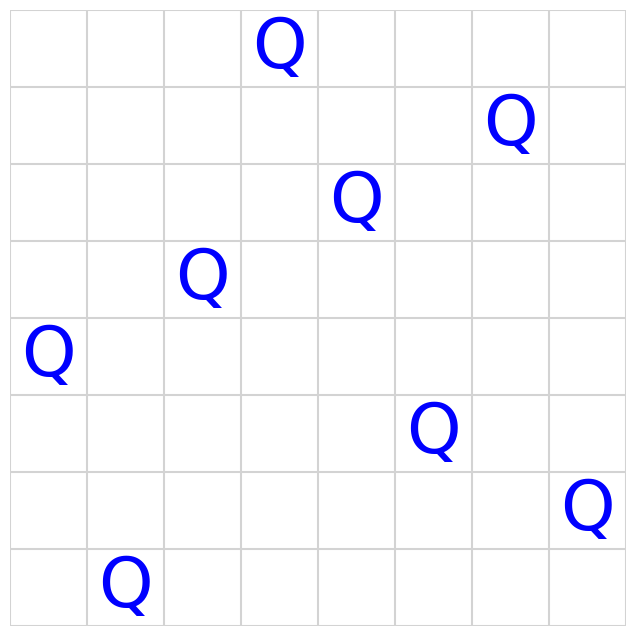

In [34]:
predict_and_vis(8, model)

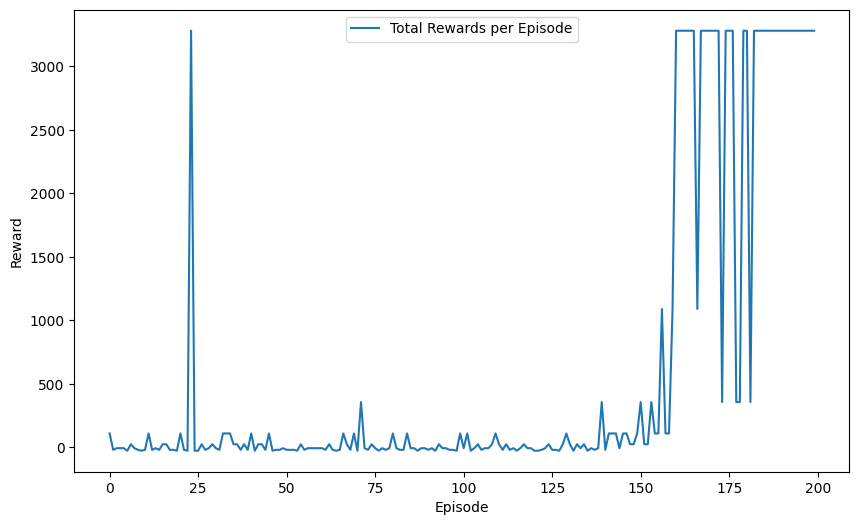

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()